<a href="https://colab.research.google.com/github/terjirapat/MADT8101-Customer-Analytics/blob/main/VOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn
!pip install pyLDAvis
!pip install umap

  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.


  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.25.2 which is incompatible.


# Topic Modeling with LDA

## Importing libraries and data

In [27]:
import pythainlp
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Wongnai review comment ครกไม้ไทยลาว (Krok Mai Thai Lao) restaurant
data = {'comment':
        ['ครกไม้ไทยลาว เอารถไปเข้าศูนย์ที่เลียบด่วน รุ่นพี่ที่เป็นเจ้าเมืองลาดพร้าวเลยมารับไปทานข้าวระหว่างรอรถค่ะ อาหารเมนูหลากหลายมาก มีวัตถุดิบตามฤดูกาลที่น่าสนใจและมีปลาแม่น้ำมากมายให้เลือกสั่งได้ วันนี้เราไปกัน 2 คน สั่งอาหารมาหลายอย่างเหมือนกันค่ะ มีตำข้าวโพดไข่เค็ม ตำหลวงพระบาง ไส้กรอกอีสาน ลาบเป็ด ไข่เจียวไข่มดแดง ปลาเนื้ออ่อนตัวเล็กทอด ต้มซุปเปอร์ตีนไก่ อาหารโดยรวมใช้ได้โอเคเลย ราคาน่ารักจนตกใจ หมดนี่หมดไปหกร้อยกว่าบาทเองค่ะ',
        'ร้านอาหารไทยลาว ครกไม้ ย่านลาดปลาเค้า ร้านยอดนิยม ช่วงกลางวัน ลูกค้าเยอะ แน่นร้านมากๆ แต่อาหารรอไม่นาน รสชาติดี เมนู มีแบบทั้งไทย แล เมนูลาว เมนู อาหารป่า มาครบ จบในที่นี่ ที่เดียวเลยจ้า ราคาไม่แพง มีทั้ง โซนด้านนอก และ ด้านในห้องแอร เลือกได้ ตามสะดวก ตามชอบเลยจ้ะ',
        'แวะมาทานอาหารเย็นหลังเสร็จงานที่วัด ดื่มด่ำบรรยากาศดีๆ ราคาไม่เเพง เเต่การบริการไม่ค่อยเวิร์ค พนักงานดูไม่ค่อยสนใจ เช่น สั่งน้ำแข็งไป 2 - 3 รอบไม่ได้ ต้องจี้ถึงจะได้ อาหารรสชาติดี บรรยากาศร้านดี ไม่ร้อนอบอ้าว',
        'ถ้าคุณยังไม่เคยสัมผัสรสชาติและวัตถุดิบอาหารอีสานขนานแท้แล้วละก้อบอกได้เลยครับว่าร้านนี้ตอบโจทย์ที่คุณตามหามาเนิ่นนาน ไข่เจียวไข่มดแดง ตำมั่วซั่วครกไม้ แกงคั่วเห็ดเผาะ แกงผักหวานไข่มดแดง หมกรังผึ้งอ่อน แม่เป้ง หอยโข่ง ต่ออ่อน ล้วนแล้วแต่เป็นเมนูที่ห้ามพลาดโดยเด็ดขาดหาทานที่ไหนไม่ได้แล้วนะครับ รสชาติอีสานขนานแท้จัดจ้านปรุงแต่งไม่เยอะแต่รสชาติแซ่บนัว การบริการดีงามครับพนักงานแบ่งโต๊ะดูแลกันอย่างใกล้ชิดอาหารรวดเร็วทันใจราคาไม่แพงแต่ก็จารไม่ได้ใหญ่มากนะครับสามารถเลือกทานได้ไหลย่าง ที่จอดรถอาจจะต้องพกดวงมาด้วยซักเล็กน้อยแต่มีพนักงานดูแลความเรียบร้อยอย่างดีครับ',
        'นานมากไม่ได้มา​งั้นจัด ไม่น่าเชื่อว่าคนเยอะมาก อาหารก็ตามรสชาติเดิมแต่ที่โดนที่สุดคือไส้กรอกย่าง และข้าวเหนียวห่อมาในใบตอง อาหารอีสานดั่งเดิม มีหลากหลายเมนู ที่นั่งเยอะมาก ทั้งมุมห้องแอร์ และมุมด้านนอก รับลมจากพัดลม พนักงานบริการได้เร็วทันใจ',
        'ร้านใหญ่ หลายสาขา คนเยอะตลอดๆ แต่เค้าต้องสั่งอะไรกันหรอ ส้มตำไทยไข่เค็ม ตำปูม้า ไม่ถูกปากแฮะ ปูม้าให้เยอะมากมายแต่ไม่สด เมนูหอยหอมนึ่ง ไม่น่าขึ้นโต๊ะเพราะมีทั้งกรวดทราย ที่ดีที่สุดคือ ลาบหมูอร่อยมาก อาหารราคาไม่แรง ปริมาณเหมาะสมและไวมาก',
        'ร้านลึกลับ​หน่อย แต่​คนเยอะ อร่อยทุกอย่าง อาหาร​มาตรฐาน​ดีหมด ลาบปลาดุก ต้มแซบ ตับหวาน​ น้ำตกหมู ส่วนปลาช่อน​นึ่ง​ลุย​สวน​ ปลาสดจริง​และ​ตัว​ใหญ่ ที่แปลกคือสั่งรังผึ้ง ต้องเอาเค็มกลบคาว ชิ้นเล็กไปหน่อย โดยรวมแล้วดีครับ',
        'เมนูอาหารอีสานท็อปฮิตติดชาร์ตอย่าง ส้มนำ ลาบ น้ำตก ต้มแซ่บ ไก่ย่าง พวกนี้กลายเป็นของเบสิคไปเลยเมื่อได้เหยียบย่างกรายมาที่ร้านแห่งนี้ เพราะมีอาหารอีสานแปลกๆ(ที่เราไม่เคยกิน)ให้เลือกสั่งมาลองมากมายหลายอย่าง จะได้สัมผัสรสชาติอีสานแท้ๆกันเลยว่าเขากินกันอะไรกันบ้าง ปรุงรสอย่างไร บางอย่างก็เป็นของกินพื้นบ้านที่เขากินกันปกติแต่ก็หาทานยากในกรุงเทพฯถ้าไม่รู้แหล่งหรือร้าน เช่น ไข่มดแดง เห็ดเผาะ เป็นต้น',
        'ร้านส้มตำลาวนะคะ ร้านใหญ่ประมาณหนึ่งเลยนะคะ พนักงานแบ่งงานเสริฟกันเป็นโซนค่ะ เมนูอาหารพอสมควรเลยนะคะ วันนี้ส้มตำลาว ปลานิลเผา หมูดำย่างแจ่ว ส้มตำลาวแซ่บดีนะคะ ปลานิลเผาดีเลยนะคะ หมูดำย่างแจ่วดีที่สุดดด นุ่มอย่างกับเนื้อค่ะ มื้อนี้จัดหนักเลย',
        'ร้านนี้ส้มตำมั่วซั่วครกไม้คือเด็ดมาก ตามด้วยแกงเห็ดเพาะ ต้มผักหวานไข่มดแดง ต้มแซ่บเอ็นหมู ร้านนี้อร่อยแทบทุกอย่าง ขนาดข้าวเหนียวยังอร่อยจริงๆ ราคาก็กลางๆแต่ชาติเริ่ดๆค่ะ ที่จอดรถก็มีเดินทางมาร้านก็ง่ายมาก',
        'เมื่อก่อนนานมากแล้ว(เกิน 10ปีมาละ) เคยได้มาทานร้านนี้ตั้งแต่สมัยเป็นร้านเล็กๆ ริมถนนอยู่ปากซอยลาดปลาเค้า 24 แต่ตอนนี้ร้านย้ายมาอยู่ในซอย และ ตัวร้านขยายใหญ่ขึ้น มีที่จอดรถสะดวกขึ้นมาก และตอนนี้เห็นว่ามีสาขา 2 แล้วด้วย สาขาที่ 2 อยู่ที่รามอินทรา 14 ถนนประเสริฐมนูญกิจ 29 (ซอยมัยลาภ)',
        'มีร้านอาหารเพียงไม่กี่ร้านที่สามารถทำอาหารที่ถ่ายทอดความเป็นอยู่ของคนท้องถิ่นนั้นๆได้ ร้านนี้คือหนึ่งในนั้น ด้วยอาหารที่นี่เป็นอาหารพื้นบ้าน วัตถุดิบใช้ของที่มีในท้องถิ่นมาทำ มันสะท้องภาพวิถีชีวิตของคนอีสานได้ชัดเจนมาก มองเห็นถึงความอุดมสมบูรณ์ของพืชพรรณธัญญาหาร ในน้ำมีปลาในนามีข้าวจริงๆ พูดถึงรสชาติบ้าง กลมกล่อม อร่อยทุกเมนู มันไม่ได้เผ็ดหรือเค็มมากเกินไป',
        'ได้ยินชื่อเสียงร้านนี้ตั้งแต่สมัยเรียนประถม จนทุกวันนี้อายุ 30 กว่า ก็พึ่งได้ไปชิม และต้องบอกว่าคุณภาพอาหาร สมราคา และรสชาติสมคำร่ำรือเช่นกัน อาหารแต่ละเมนูจะมาในปริมาณที่ไม่เยอะมาก และราคาถูก ซึ่งทำให้เราสามารถเลือกสั่งและเลือกชิมได้หลายเมนู เสียอย่างเดียว.. บางครั้งไม่มีที่จอดรถ ถ้าวันไหนรอไม่ไหวก็อกหักกลับบ้านกันเลยทีเดียว',
        'คือร้านนี้ต้องลองได้ยินชื่อนานละ ในที่สุด ซักที หมกรังผึ้งจิ้มเกลือ เค็มๆมันๆ หวานหน่อยๆ เลอค่า ตบด้วยส้มตำรสชาติไม่ต้องห่วง ปางตาย เมนูอีกหลายอย่างที่ต้องกลับไปลอง บริกรน่ารักบริการ ok',
        'เป็นร้านที่มาบ่อยอีกร้านค่ะ แต่ก็ยังลองไม่ครบทุกเมนูสักที ร้านดั้งเดิมที่คนเยอะตลอดเลย เมนูโปรดคือหมูดำหมักย่างแจ่ว จานเดียวไม่เคยพอ และก้อยไข่มดแดง แต่วันนี้เลือกแบบหมกค่ะ ก็อร่อยดีกรุบๆ ลาบเช้มข้น ไม่จัดจ้านมาก หอยแครงเผาอร่อยกว่าแบบลวกค่ะ ข้าวเหนียวเค้านุ่มดี อาหารมาไวด้วย ทั้งๆที่คนแน่น',
         'ครกไม้ไทยลาว ร้านกลางกรุง ได้บรรยากาศอิสานดีจริงๆ ค่ะ รสชาติแซ่บหลาย เมนูหน้าตาแปลกเพียบค่ะ (คนอื่นอาจไม่แปลก อิอิ) เช่น รังผึ้งย่าง ฟักทองนึ่ง บางมุมแต่งแนวออกโบราณ เก๋ไก๋ไม่เบา ชอบไก่ทอดเกลือ มาเป๋นตัวเลยจ้า เด็ดจ้า',
         'ตั้งใจมาทานมานานแล้ว ร้านนี้ได้รับรางวัลเกี่ยวกับการตำส้มตำหลายปี ด้านหน้าจอดได้ประมาณสามคัน แต่ด้านหลังมีที่จอดเพียบ เนื้อย่างติดมัน-เสือร้องไห้อันนี้ให้สี่ดาว มีบางชิ้นเหนียวไปนิด สั่งสองจานเลย หอยแครงลวกแพงไปหน่อย น้ำจิ้มยังไม่สะใจครับ ซุปหน่อไม้หั่นเป็นชิ้นครับ รสชาติใช้ได้ ส้มตำปูอันนี้ผมเฉยๆ ข้าวเหนียวห่อใบตองแปลกดีตำมั่วซั่วครกไม้อันนี้ดีครัย นับจาก แกล้มด้วยเบียน์โฮการ์เด้นท์',
         'ร้านครกไม้ไทยลาว ร้านอาหารอิสานหลากหลายหากินยากมีตั้งแต่เมนูธรรมดาส้มตำลาบน้ำตกยันเมนูแปลกๆอย่างเช่น หมกรังผึ้ง,ยำไข่ปลาดุกนา,แกงคั่วเห็ดเผาะ อาหารราคาไม่แพงเริ่มต้นที่50บาทจานไม่ใหญ่มากคนเยอะแต่อาหารมาเร็วอยู่ค่ะบรรยากาศร้านจะมืดๆใครที่ชอบเมนูอิสานแปลกหาทานยากต้องที่นี่เลย',
         'เป็นที่ชอบมาทานหลายครั้งเลย ร้านหายไม่ยากเข้าซอยมา 100 เมตร อยู่ขวามือ อาจจะหายที่จอดรถยนต์​ยากนิดนึง อาหารเน้นรสจัดคนชอบอีสานแท้ๆแนะนำ แต่ถ้าเป็นคนไม่ทานเผ็ดมาก แนะนำสั่งเผ็ดน้อย ตบท้ายด้วยของหวาน เป็นลอด​ช่อง อร่อยมาก โดยรวมดีครับ',
         'ร้านนี้เป็นร้านอาหารอีสานแซ่บๆ รสชาติถูกปากจริงๆ กับครกไม้ไทยแล้วแถววังหินโชคชัย 4 ครั้งนี้มาทานเบาๆกับเพื่อนๆ สั่งไปหลายเมนู ทั้งหม่ำ น้ำตก ส้มตำ แหนม เป็นต้น ขอบอกว่ารสชาติแซ่บถูกปากเพื่อนๆแน่นอน หากใครแวะมาแถวนี้ก็เชิญเลยครับ',
         'ประทับใจร้าน ดูอบอุ่นดี เมนูมา ตกใจ อาหารราคาถือว่าไม่แพง เมนูอาหารอิสาน อาหารหายาก รสชาติอร่อย สั่งมาเป็นชุดๆ หายเป็นชุดๆแค่ 3 คน อาหาร 12 จาน อิ่มสุดๆ อร่อย ต้องลองอีก และคิดว่าจะไม่พลาด และแนะนำ เพื่อนๆต่อด้วย!!!',
         'วันนี้อยากส้มตำมากๆเลยแวะมาทานที่ครกไม้ไทยลาวค่ะ เคยมาหลายรอบแล้ว แต่ไม่เคยได้รีวิวเลยค่ะ วันนี้เลยจัดซะหน่อย เริ่มจากเมนูดสรฟก่อนซุปมะเขือ อร่อยกลมกล่อม และตำซั่ว ตำข้าวโพด อร่อย แม้ว่าจะมาแนวจืดไปสักนิด ปลาคังลวก ปีกไก่ทอด กบย่าง ลาบหมู มีหักคะแนนนิดนึงตรงที่อาหารมาขาดช่วงประมาณ15นาทีค่ะ ส้มตำมาเร็ว แต่ของย่างมาช้ามว้ากๆๆๆๆ ขอเติมผักกะไม่ให้ด้วยคร้า',
         'ร้านนี้อาหารรสชาติเผ็ดนะครับ ใครที่คิดว่ากินเผ็ดแล้วเจอร้านนี้อย่าสั่งเผ็ดเพิ่มนะครับ ผมขออนุญาติเตือนไว้ก่อน เพราะผมเองก็โดนมาแล้วครับ ฮ่าๆๆ นอกจากส้มตำที่รสชาติจัดจ้านแล้ว คอหมูย่างที่มาพร้อมกับน้ำจิ้มก็อร่อยเหาะครับ ร้านอยู่ภายในซอยอีกครั้งนะครับ ถ้าเข้ามาจากถนนหลักแล้ว',
         'ร้านกว้างขวาง มีที่จอดรถแต่อาจจะไม่มาก อาหารเมนูให้เลือกเยอะมากโดยเฉพาะส้มตำ ที่ร้านแนะนำคือตำมั่วซั่ว คล้ายๆตำป่า รสชาติ แต่ส่วนตัวคิดว่าตำอย่างอื่นที่ไม่ใส่ปลาร้ารสชาติธรรมดา อาหารอื่นๆก็อร่อย เนื้อย่างติดมันน้ำจิ้มแจ่วเค็มไปนิด แกงเห็ดเผาะรสมันเข้มแต่ให้น้อย พนักงานไม่ค่อยมาดูแล ตามตัวยาก',
         'มื้อเย็นอยากกินมาก แกงคั่วหอยขม เลยมาที่ร้านนี้ ครัวครกไม้ ที่นี่เขาทำอร่อยจริง ไม่คราว วันนี้หิวจัด สั่งมาเยอะมากๆ แต่ก็กินหมดนะ เพราะทุกอย่างอร่อย ไม่เผ็ดมาก รสชาติกลางๆแต่อร่อยทุกอย่าง แต่อาหารแต่ละจานน้อยไปนิด แต่ก็โอเคคะมีให้เลือกเยอะ ของอิสานๆทั้งนั้น',
         'ถ้าอยากแซ่บอาหารอีสารนึกถึงร้านนี้ตลอดรสชาติจัดจ้านแต่อร่อยเข้าเครื่อง โดยเฉพาะตำครกไม้ไทยลาวไม่รู้จำชื่อถูกไหมอันนี้สั่งเผ็ดปานกลางก็ยังรสจัด เอาซะเหงือออกเลย. เมนูหมกกุ้งฝอย อร่อยดีแต่หนวดกุ้งชอบทิ่มเพดานลิ้นจิง ต้มแซ่บเอ็นหมู รสชาติถึงเครื่องเคี้ยวเอ็นหนุบๆ และเมนูอื่นๆก็อร่อยไม่แพ้กันลองไปลองได้แต่ที่จอดรถมีค่อนข้างจำกัดสักหน่อย',
         'ร้านอาหารอีสานที่มีเมนูให้เลือกเยอะมาก วัตถุดิบที่หากินยากๆก็มีเยอะมากเช่นกัน แกงผักหวานไข่มดแดง รสชาติเยี่ยม ซดได้เริ่อยๆ แต่เมนูที่ยกให้เยี่ยมที่สุดคือ เนื้อย่างติดมัน-เสือร้องไห้ ถือว่าย่างได้ดี ความสุกประมาน medium-rare เลยทีเดียว อีกทั้งการหมักที่เหมาะสม เนื้อย่างหอม นุ่ม อร่อยมากจริงๆ',
         'อร่อยมากครับร้านนี้ อาหารรสชาติอีสานแท้ๆหากินยาก',
         'อร่อยจริงจัง อร่อยสมคำรำรือ คนเยอะ บริการดี บริการไว อาหารอีสาน ที่ใครๆหลายคนชอบเพรสะฉะนั้นคนที่ไม่เคยทาน ต้องลองมาทานสะน่ะ รับริงจะติดใจ ควาใอร่อยของอาหารร้านนี้ เราช๊อบชอบ มีโอกาศจะไปทานอีกแน่นอนจ้า',
         'บรรยากาศในร้่านร่มรื่นดี รสชาดอร่อย มีเมนูให้เลือกหลากหลาย เลือกไม่ถูกเลยทีเดียว แต่อาหารส่วนใหญ่จะออกหวานหน่อย แต่โดยรวมก็ใช้ได้ สำหรับใครที่ชอบทานปลา ต้องลอง ปลาทับทึมย่างเกลือ เนื้อปลาหวาน สด อร่อยมาก และอีกเมนู คือ ปลาช่อนทอดเกลือ เค้าจะทอดได้กรอบมาก และอีกเมนูที่สุดแสนอร่อย ต้องนี่เลย!!! แกงคั่วเห็ดเพอะ แซบหลาย!!!!']}

df = pd.DataFrame(data)
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment
25,ถ้าอยากแซ่บอาหารอีสารนึกถึงร้านนี้ตลอดรสชาติจั...
26,ร้านอาหารอีสานที่มีเมนูให้เลือกเยอะมาก วัตถุดิ...
27,อร่อยมากครับร้านนี้ อาหารรสชาติอีสานแท้ๆหากินยาก
28,อร่อยจริงจัง อร่อยสมคำรำรือ คนเยอะ บริการดี บร...
29,บรรยากาศในร้่านร่มรื่นดี รสชาดอร่อย มีเมนูให้เ...


## Tokenize Words with pythainlp

In [29]:
stop_word = list(pythainlp.corpus.thai_stopwords())
rm_word = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ร้าน', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ']
screenword = stop_word + rm_word

def tokenize_n_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize( str(sentence), engine = 'newmm' )
    for i in words :
        if i not in screenword :
            merged = merged + ',' + i
    return merged[1:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
df['tokenized'] = df['comment'].apply(lambda x: tokenize_n_space(x))
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment,tokenized
25,ถ้าอยากแซ่บอาหารอีสารนึกถึงร้านนี้ตลอดรสชาติจั...,"แซ่บ,อาหาร,อี,สาร,นึกถึง,รสชาติ,จัดจ้าน,อร่อย,..."
26,ร้านอาหารอีสานที่มีเมนูให้เลือกเยอะมาก วัตถุดิ...,"ร้านอาหาร,อีสาน,เมนู,เลือก,วัตถุดิบ,หากิน,แกง,..."
27,อร่อยมากครับร้านนี้ อาหารรสชาติอีสานแท้ๆหากินยาก,"อร่อย,อาหาร,รสชาติ,อีสาน,แท้ๆ,หากิน"
28,อร่อยจริงจัง อร่อยสมคำรำรือ คนเยอะ บริการดี บร...,"อร่อย,อร่อย,สม,รำ,คน,บริการ,ดี,บริการ,ไว,อาหาร..."
29,บรรยากาศในร้่านร่มรื่นดี รสชาดอร่อย มีเมนูให้เ...,"บรรยากาศ,ร้่าน,ร่มรื่น,ดี,รส,ชาด,อร่อย,เมนู,เล..."


In [31]:
doc = df['tokenized'].to_list()
texts = [ [i for i in dc.split(',')] for dc in doc ]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['2', 'ข้าวโพด', 'คน', 'ครก', 'ซุปเปอร์', 'ด่วน', 'ตกใจ', 'ตัวเล็ก', 'ตามฤดูกาล', 'ตำ', 'ตีน', 'ต้ม', 'ทอด', 'ทานข้าว', 'น่ารัก', 'น่าสนใจ', 'บาท', 'ปลา', 'มดแดง', 'รถ', 'รอ', 'ราคา', 'รุ่นพี่', 'ลาดพร้าว', 'ลาบ', 'ลาว', 'วัตถุดิบ', 'ศูนย์', 'สั่ง', 'สั่งอาหาร', 'หกร้อย', 'หลวงพระบาง', 'หลากหลาย', 'หลายอย่าง', 'อาหาร', 'อีสาน', 'เจ้าเมือง', 'เนื้ออ่อน', 'เป็ด', 'เมนู', 'เลียบ', 'เลือก', 'เหมือนกัน', 'แม่น้ำ', 'โดยรวม', 'โอเค', 'ใช้ได้', 'ไก่', 'ไข่', 'ไข่เค็ม', 'ไข่เจียว', 'ไทย', 'ไม้', 'ไส้กรอก', 'กลางวัน', 'จบ', 'ชอบ', 'ดี', 'ด้านนอก', 'ด้านใน', 'ที่นี่', 'ป่า', 'ยอดนิยม', 'ย่าน', 'ร', 'รสชาติ', 'ร้านอาหาร', 'ลาด', 'ลูกค้า', 'สะดวก', 'ห้อง', 'เค้า', 'แน่น', 'แพง', 'แล', 'แอ', 'โซน', '-', '3', 'ง', 'งาน', 'จี้', 'ดื่มด่ำ', 'ดู', 'ทาน', 'ที่วัด', 'น้ำแข็ง', 'บรรยากาศ', 'บริการ', 'พนักงาน', 'รอบ', 'ร้อน', 'สนใจ', 'อบอ้าว', 'อาหารเย็น', 'เ', 'เพ', 'เวิร์ค', 'เเต่', 'แวะ', 'ก้อ', 'ขนาน', 'จัดจ้าน', 'จาร', 'ซัก', 'ดวง', 'ดีงาม', 'ดูแล', 'ตอบ', 'ตามหา', 'ที่จอดรถ', 'นัว', 'ปรุงแต่

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
gensim_corpus = [ dictionary.doc2bow(tx, allow_update = True) for tx in texts ]
word_frq = [ [ (dictionary[ides], frq) for ides, frq in coup ] for coup in gensim_corpus ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modeling using LDA

In [33]:
num_topic = 30
chunksize = 4000 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 50
eval_number = 1 # more number, more compute time spending

# Make index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

%time
model = gensim.models.LdaModel( corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto'
                               , iterations=iterations, num_topics=num_topic, passes=passes, eval_every=eval_number )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


### Predict Topics

In [34]:
model.show_topic(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('เป๋', 0.0020202019),
 ('แต่ง', 0.0020202019),
 ('หน้าตา', 0.0020202019),
 ('อิสาน', 0.0020202019),
 ('อิอิ', 0.0020202019),
 ('เก๋ไก๋', 0.0020202019),
 ('น', 0.0020202019),
 ('เพียบ', 0.0020202019),
 ('ไม่เบา', 0.0020202019),
 ('โบราณ', 0.0020202019)]

In [35]:
df['topics'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment,tokenized,topics,score
25,ถ้าอยากแซ่บอาหารอีสารนึกถึงร้านนี้ตลอดรสชาติจั...,"แซ่บ,อาหาร,อี,สาร,นึกถึง,รสชาติ,จัดจ้าน,อร่อย,...",19,0.990101
26,ร้านอาหารอีสานที่มีเมนูให้เลือกเยอะมาก วัตถุดิ...,"ร้านอาหาร,อีสาน,เมนู,เลือก,วัตถุดิบ,หากิน,แกง,...",4,0.983790
27,อร่อยมากครับร้านนี้ อาหารรสชาติอีสานแท้ๆหากินยาก,"อร่อย,อาหาร,รสชาติ,อีสาน,แท้ๆ,หากิน",13,0.914189
28,อร่อยจริงจัง อร่อยสมคำรำรือ คนเยอะ บริการดี บร...,"อร่อย,อร่อย,สม,รำ,คน,บริการ,ดี,บริการ,ไว,อาหาร...",14,0.984091
29,บรรยากาศในร้่านร่มรื่นดี รสชาดอร่อย มีเมนูให้เ...,"บรรยากาศ,ร้่าน,ร่มรื่น,ดี,รส,ชาด,อร่อย,เมนู,เล...",15,0.988131


# Document Clustering

In [40]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model
model = hub.load(module_url)

df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment,tokenized,topics,score
25,ถ้าอยากแซ่บอาหารอีสารนึกถึงร้านนี้ตลอดรสชาติจั...,"แซ่บ,อาหาร,อี,สาร,นึกถึง,รสชาติ,จัดจ้าน,อร่อย,...",19,0.990101
26,ร้านอาหารอีสานที่มีเมนูให้เลือกเยอะมาก วัตถุดิ...,"ร้านอาหาร,อีสาน,เมนู,เลือก,วัตถุดิบ,หากิน,แกง,...",4,0.983790
27,อร่อยมากครับร้านนี้ อาหารรสชาติอีสานแท้ๆหากินยาก,"อร่อย,อาหาร,รสชาติ,อีสาน,แท้ๆ,หากิน",13,0.914189
28,อร่อยจริงจัง อร่อยสมคำรำรือ คนเยอะ บริการดี บร...,"อร่อย,อร่อย,สม,รำ,คน,บริการ,ดี,บริการ,ไว,อาหาร...",14,0.984091
29,บรรยากาศในร้่านร่มรื่นดี รสชาดอร่อย มีเมนูให้เ...,"บรรยากาศ,ร้่าน,ร่มรื่น,ดี,รส,ชาด,อร่อย,เมนู,เล...",15,0.988131


In [41]:
umap_embed_comments_array = model(df['comment'].values).numpy()
umap_embed_comments_array

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 0.06239085,  0.02341959, -0.05474147, ..., -0.07703752,
         0.03565162, -0.05284417],
       [ 0.05151007, -0.00891536, -0.01016504, ..., -0.03122991,
         0.02428049, -0.0585911 ],
       [ 0.06771431,  0.02843144,  0.03431313, ...,  0.01575895,
         0.05975469,  0.01577946],
       ...,
       [-0.08424967, -0.06205361, -0.01469362, ..., -0.02696568,
        -0.0136725 , -0.06949568],
       [ 0.10663341, -0.01697206,  0.0146763 , ...,  0.05457323,
        -0.00455384,  0.07856175],
       [ 0.06915145, -0.01459435, -0.07304476, ..., -0.0496542 ,
         0.02691961, -0.05151155]], dtype=float32)

In [42]:
# reducer = umap.UMAP(random_state=42,n_components=25)
# umap_embed_comments_array = reducer.fit_transform(embed_cm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d51ffc9b490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/thread

Text(0, 0.5, 'WCSS')

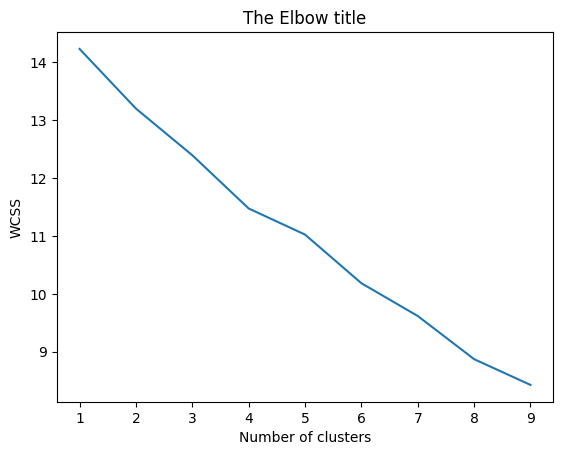

In [43]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot
wcss=[]
max_k = 10

for i in range(1, max_k):
    kmeans = KMeans(i)
    kmeans.fit(umap_embed_comments_array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    number_clusters = range(1, max_k)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [44]:
#run kmeans with no. of clusters you see fit the most
k = 4
kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)
df['KMeans ID'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
#merge all reviews of each cluster into one big sentence
df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['comment'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
df_kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,KMeans ID,texts
0,0,8 ร้านส้มตำลาวนะคะ ร้านใหญ่ประมาณหนึ่งเลยน...
1,1,0 ครกไม้ไทยลาว เอารถไปเข้าศูนย์ที่เลียบด่ว...
2,2,11 มีร้านอาหารเพียงไม่กี่ร้านที่สามารถทำอาห...
3,3,10 เมื่อก่อนนานมากแล้ว(เกิน 10ปีมาละ) เคยได...


In [47]:
#create regex compiler for removal of a character you don't want
special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
#create regex compiler for removal of any emoji
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F" # emoticons
u"\U0001F300-\U0001F5FF" # symbols & pictographs
u"\U0001F680-\U0001F6FF" # transport & map symbols
u"\U0001F1E0-\U0001F1FF" # flags (iOS)
"]+", flags=re.UNICODE)

#create regex compiler for removal of digit
number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space
space_pattern = re.compile("\s+")
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:12: DeprecationWarning: invalid escape sequence '\s'
<>:12: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-48-1b28a965a998>:12: DeprecationWarning: invalid escape sequence '\s'
  space_pattern = re.compile("\s+")


In [49]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ร้าน', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ']
screening_words = stopwords + removed_words

# words = new_words.union(thai_words())
# custom_dictionary_trie = Trie(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
def tokenize_to_list(sentence):
    merged = []
    words = pythainlp.word_tokenize(str(sentence), engine='newmm')

    for word in words:
        if word not in screening_words:
            merged.append(word)
    return merged

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x:collections.Counter(x).most_common())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
df_kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,KMeans ID,texts,texts_tokenized,texts_count
0,0,ร้านส้มตำลาวนะคะร้านใหญ่ประมาณหนึ่งเลยนะคะพนตั...,"[ส้มตำ, ลาว, นะคะ, นะคะ, พน, ใจมา, ทาน, รับราง...","[(ส้มตำ, 2), (ลาว, 2), (นะคะ, 2), (ทาน, 2), (พ..."
1,1,ครกไม้ไทยลาวเอารถไปเข้าศูนย์ที่เลียบด่วนรุ่นร้...,"[ครก, ไม้, ไทย, ลาว, รถ, ศูนย์, เลียบ, ด่วน, ร...","[(อาหาร, 6), (ครก, 5), (ไม้, 5), (ไทย, 4), (ลา..."
2,2,มีร้านอาหารเพียงไม่กี่ร้านที่สามารถทำอาหารที่ถ...,"[ร้านอาหาร, กี่, ทำอาหาร, ถ, ลอง, ได้ยิน, ชื่อ...","[(รสชาติ, 3), (ร้านอาหาร, 2), (อีสาน, 2), (อาห..."
3,3,เมื่อก่อนนานมากแล้ว(เกินปีมาละ)เคยได้มาทาน,"[ปี, ทาน]","[(ปี, 1), (ทาน, 1)]"


In [58]:
# show top key word of each cluster

top_n_words = 10
for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_n_words]}\n")

Cluster ID : 0

Most common words include : [('ส้มตำ', 2), ('ลาว', 2), ('นะคะ', 2), ('ทาน', 2), ('พน', 1), ('ใจมา', 1), ('รับรางวัล', 1), ('เกี่ยว', 1), ('แวะ', 1), ('ครก', 1)]

Cluster ID : 1

Most common words include : [('อาหาร', 6), ('ครก', 5), ('ไม้', 5), ('ไทย', 4), ('ลาว', 4), ('อร่อย', 4), ('เมนู', 4), ('ดี', 4), ('อี', 3), ('ร้านอาหาร', 2)]

Cluster ID : 2

Most common words include : [('รสชาติ', 3), ('ร้านอาหาร', 2), ('อีสาน', 2), ('อาหาร', 2), ('กี่', 1), ('ทำอาหาร', 1), ('ถ', 1), ('ลอง', 1), ('ได้ยิน', 1), ('ชื่อ', 1)]

Cluster ID : 3

Most common words include : [('ปี', 1), ('ทาน', 1)]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
